<a href="https://colab.research.google.com/github/glazar01/UZH-essentials-project/blob/main/Lyrics%20Emotions%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lyrics Emotions Project

## Our Data

Before doing anything with data, we need to import the necessary libraries to read and manipulate the data.

In [3]:
import pandas as pd

In [4]:
single_label = pd.read_csv('data/SingleLabel.csv', encoding='utf-8')
single_label.head()

,artist,genre,title,album,year,lyrics,label
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness


In [5]:
labels = single_label['label']
unique_labels = labels.unique()
unique_labels

array(['Sadness', 'Tension', 'Tenderness'], dtype=object)

The above dataset contains several headers that give us information on the collected songs, such as the artist, genre, title, etc. The final column, "label", along with the "lyrics" column is to be used for the Classification problem.

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Let's visualize and save the word clouds for 'Sadness', 'Tension', 'Tenderness' classes in single-label dataset

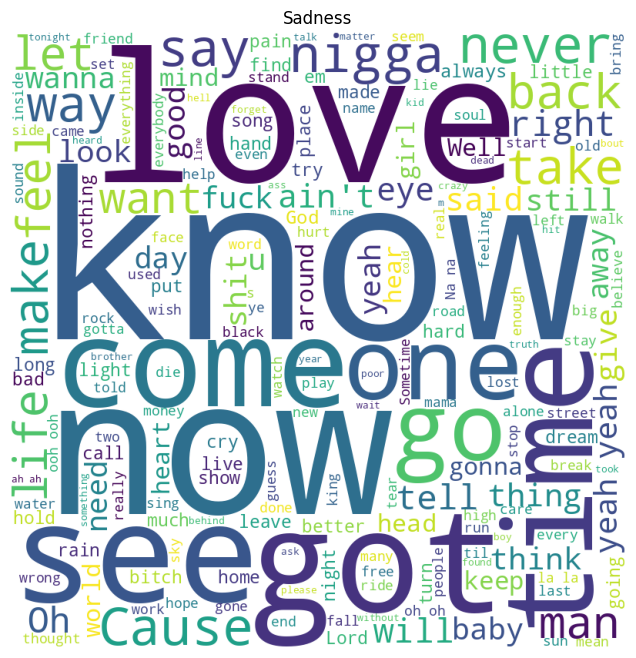

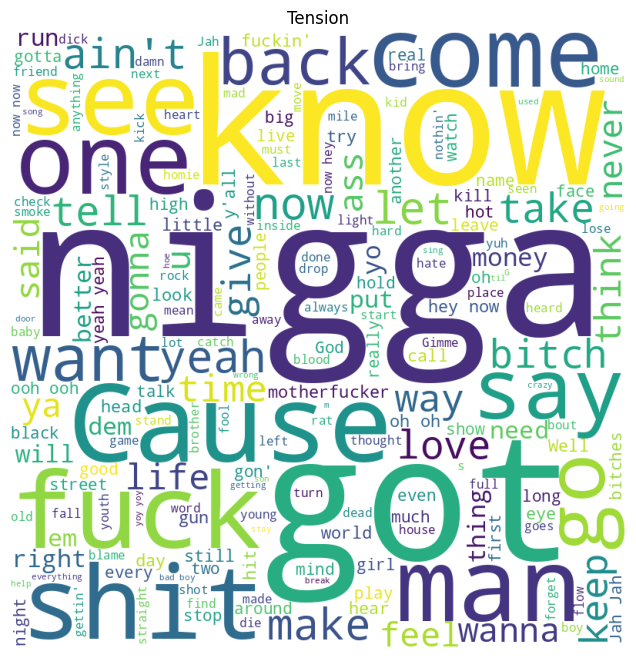

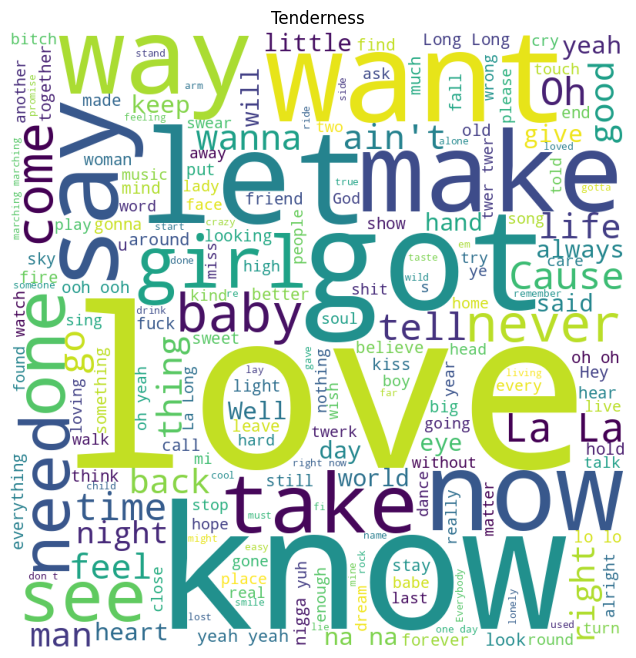

In [7]:
word_dict = dict()
for val in unique_labels:
    sentences = ""
    for l in single_label.loc[single_label['label'] == val]['lyrics']:
        sentences += " " + l
    word_dict[val] =sentences
for key in word_dict:
    word_cloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 5).generate(word_dict[key])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.axis("off")
    plt.title(str(key))
    plt.imshow(word_cloud)
    plt.savefig(str(key) + ".png")

In [8]:
multi_label = pd.read_csv('data/MultiLabel.csv', encoding='utf-8')
multi_label.head()

,artist,genre,title,album,year,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,"Power, Tension"
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,"Amazement, Calmness, Solemnity, Tenderness"
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...","Joyful activation, Sadness, Tension"
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,"Amazement, Calmness, Joyful activation"


This dataset contains the same information but differs in the final column, with it being labels and containing multiple labels for each example. This dataset is to be used for the Multi-Label Classification problem.

## Data Exploration and Preprocessing

### A: Classification

Let's take a look at the classes distribution, before transforming the data to model-interpretable format.

In [9]:
single_label['label'].value_counts()

Sadness       569
Tenderness    326
Tension       265
Name: label, dtype: int64

Sadness is the most represented class, with Tenderness and Tension following.

Import all the necessary packages for single-label classification problem.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from nltk.tokenize import WordPunctTokenizer
import nltk

After importing the neccessary libraries, we split the data in X and y (the "lyrics" data and the "label" data)

In [11]:
X = single_label['lyrics']
y = single_label['label']

Defining the NLTK POS Tagger

In [12]:
class POSTogging:
    def __init__(self):
        self.wpt = WordPunctTokenizer()
    def __call__(self, doc):
        text = self.wpt.tokenize(doc)
        return [word + '/' + tag for word, tag in nltk.pos_tag(text)]

Defining the n-gram models :- Unigram, Bigram, Trigram, Unigram + Bigram, Bigram + Trigram, Unigram + Bigram  + Trigram

In [13]:
n_gram_pipeline = dict()
n_gram_pipeline['Unigram'] = (1, 1)
n_gram_pipeline['Bigram'] = (2, 2)
n_gram_pipeline['Trigram'] = (3, 3)
n_gram_pipeline['Unigram + Bigram'] = (1, 2)
n_gram_pipeline['Bigram + Trigram'] = (1, 1)
n_gram_pipeline['Unigram + Bigram  + Trigram'] = (1, 3)

Set up a TF/IDF Vectorizer to transform our lyrics into features that indicate their belonging to one of the three classes, using various n-gram models.

In [14]:
n_gram_tfidf_features_pipeline = dict()
for features in n_gram_pipeline.keys():
        n_gram_tfidf_features_pipeline[features] = TfidfVectorizer(min_df=3, max_features=3000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=n_gram_pipeline[features],
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")
        n_gram_tfidf_features_pipeline[str(features) + " + POS"] = TfidfVectorizer(min_df=3, max_features=3000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=n_gram_pipeline[features],
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english", tokenizer=POSTogging())

Split the dataset into train and test sets.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

We then define different classifiers - LinearSVC, Logistic Regression, Decision Tree, Random Forest and Multi-layer Perceptron and create a pipeline.

In [16]:
models_pipeline = dict()
models_pipeline['Linear SVC'] = LinearSVC(random_state=0, tol=1e-5)
models_pipeline['Logistic Regression'] = LogisticRegression(solver='lbfgs', multi_class='auto')
models_pipeline['Decision Tree'] = DecisionTreeClassifier(max_depth=5)
models_pipeline['Random Forest'] = RandomForestClassifier(max_depth=5, n_estimators=10)
models_pipeline['MLP (ANN)'] = MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1500)

To plot the confusion matrix.

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Ref: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout(pad=5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Then we fit and transform the data, predict the accuracy from different classifiers. Then 5-fold cross validation's mean accuracy is also taken into consideration.

In [18]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Model : Features : Model Accuracy : 5-fold cross-validation mean accuracy
Linear SVC :Unigram :0.61 :0.59 (+/- 0.08)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB', 'anywhere/RB', 'are/VBP', 'around/IN', 'as/IN', 'at/IN', 'back/RB', 'be/VB', 'became/VBD', 'because/IN', 'become/NN', 'becomes/NNS', 'becoming/VBG', 'been/VBN', 'before/IN', 'beforehand/NN', 'behind/IN', 'being/VBG', 'below/IN', 'beside/NN', 'besides/I

Linear SVC :Unigram + POS :0.60 :0.60 (+/- 0.07)
Linear SVC :Bigram :0.53 :0.51 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB', 'anywhere/RB', 'are/VBP', 'around/IN', 'as/IN', 'at/IN', 'back/RB', 'be/VB', 'became/VBD', 'because/IN', 'become/NN', 'becomes/NNS', 'becoming/VBG', 'been/VBN', 'before/IN', 'beforehand/NN', 'behind/IN', 'being/VBG', 'below/IN', 'beside/NN', 'besides/I

Linear SVC :Bigram + POS :0.56 :0.56 (+/- 0.05)
Linear SVC :Trigram :0.51 :0.48 (+/- 0.05)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB', 'anywhere/RB', 'are/VBP', 'around/IN', 'as/IN', 'at/IN', 'back/RB', 'be/VB', 'became/VBD', 'because/IN', 'become/NN', 'becomes/NNS', 'becoming/VBG', 'been/VBN', 'before/IN', 'beforehand/NN', 'behind/IN', 'being/VBG', 'below/IN', 'beside/NN', 'besides/I

Linear SVC :Trigram + POS :0.49 :0.52 (+/- 0.06)
Linear SVC :Unigram + Bigram :0.61 :0.57 (+/- 0.04)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB', 'anywhere/RB', 'are/VBP', 'around/IN', 'as/IN', 'at/IN', 'back/RB', 'be/VB', 'became/VBD', 'because/IN', 'become/NN', 'becomes/NNS', 'becoming/VBG', 'been/VBN', 'before/IN', 'beforehand/NN', 'behind/IN', 'being/VBG', 'below/IN', 'beside/NN', 'besides/I

Linear SVC :Unigram + Bigram + POS :0.58 :0.60 (+/- 0.02)
Linear SVC :Bigram + Trigram :0.61 :0.59 (+/- 0.08)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB', 'anywhere/RB', 'are/VBP', 'around/IN', 'as/IN', 'at/IN', 'back/RB', 'be/VB', 'became/VBD', 'because/IN', 'become/NN', 'becomes/NNS', 'becoming/VBG', 'been/VBN', 'before/IN', 'beforehand/NN', 'behind/IN', 'being/VBG', 'below/IN', 'beside/NN', 'besides/I

Linear SVC :Bigram + Trigram + POS :0.60 :0.60 (+/- 0.07)
Linear SVC :Unigram + Bigram  + Trigram :0.60 :0.57 (+/- 0.05)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a/DT', 'about/IN', 'above/IN', 'across/IN', 'after/IN', 'afterwards/NNS', 'again/RB', 'against/IN', 'all/DT', 'almost/RB', 'alone/RB', 'along/IN', 'already/RB', 'also/RB', 'although/IN', 'always/RB', 'am/VBP', 'among/IN', 'amongst/NN', 'amoungst/NN', 'amount/NN', 'an/DT', 'and/CC', 'another/DT', 'any/DT', 'anyhow/NN', 'anyone/NN', 'anything/NN', 'anyway/RB', 'anywhere/RB', 'are/VBP', 'around/IN', 'as/IN', 'at/IN', 'back/RB', 'be/VB', 'became/VBD', 'because/IN', 'become/NN', 'becomes/NNS', 'becoming/VBG', 'been/VBN', 'before/IN', 'beforehand/NN', 'behind/IN', 'being/VBG', 'below/IN', 'beside/NN', 'besides/I

Linear SVC :Unigram + Bigram  + Trigram + POS :0.59 :0.59 (+/- 0.04)
Logistic Regression :Unigram :0.64 :0.61 (+/- 0.01)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Logistic Regression :Unigram + POS :0.64 :0.60 (+/- 0.03)
Logistic Regression :Bigram :0.58 :0.53 (+/- 0.02)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Logistic Regression :Bigram + POS :0.61 :0.58 (+/- 0.03)
Logistic Regression :Trigram :0.51 :0.48 (+/- 0.06)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Logistic Regression :Trigram + POS :0.54 :0.54 (+/- 0.03)
Logistic Regression :Unigram + Bigram :0.64 :0.59 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Logistic Regression :Unigram + Bigram + POS :0.63 :0.60 (+/- 0.03)
Logistic Regression :Bigram + Trigram :0.64 :0.61 (+/- 0.01)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Logistic Regression :Bigram + Trigram + POS :0.64 :0.60 (+/- 0.03)
Logistic Regression :Unigram + Bigram  + Trigram :0.63 :0.59 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Logistic Regression :Unigram + Bigram  + Trigram + POS :0.62 :0.60 (+/- 0.02)
Decision Tree :Unigram :0.60 :0.56 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree :Unigram + POS :0.58 :0.52 (+/- 0.04)
Decision Tree :Bigram :0.54 :0.51 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree :Bigram + POS :0.50 :0.53 (+/- 0.03)
Decision Tree :Trigram :0.52 :0.49 (+/- 0.01)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree :Trigram + POS :0.55 :0.51 (+/- 0.05)
Decision Tree :Unigram + Bigram :0.57 :0.56 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree :Unigram + Bigram + POS :0.55 :0.53 (+/- 0.04)
Decision Tree :Bigram + Trigram :0.60 :0.56 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree :Bigram + Trigram + POS :0.57 :0.52 (+/- 0.04)
Decision Tree :Unigram + Bigram  + Trigram :0.59 :0.55 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree :Unigram + Bigram  + Trigram + POS :0.56 :0.52 (+/- 0.03)
Random Forest :Unigram :0.54 :0.52 (+/- 0.04)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random Forest :Unigram + POS :0.53 :0.53 (+/- 0.05)
Random Forest :Bigram :0.52 :0.49 (+/- 0.01)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random Forest :Bigram + POS :0.51 :0.51 (+/- 0.00)
Random Forest :Trigram :0.52 :0.49 (+/- 0.02)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random Forest :Trigram + POS :0.52 :0.50 (+/- 0.02)
Random Forest :Unigram + Bigram :0.54 :0.52 (+/- 0.05)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random Forest :Unigram + Bigram + POS :0.56 :0.54 (+/- 0.03)
Random Forest :Bigram + Trigram :0.56 :0.51 (+/- 0.04)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random Forest :Bigram + Trigram + POS :0.56 :0.53 (+/- 0.04)
Random Forest :Unigram + Bigram  + Trigram :0.57 :0.51 (+/- 0.04)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Random Forest :Unigram + Bigram  + Trigram + POS :0.54 :0.53 (+/- 0.04)
MLP (ANN) :Unigram :0.60 :0.51 (+/- 0.13)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLP (ANN) :Unigram + POS :0.59 :0.56 (+/- 0.09)
MLP (ANN) :Bigram :0.52 :0.48 (+/- 0.05)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLP (ANN) :Bigram + POS :0.56 :0.54 (+/- 0.02)
MLP (ANN) :Trigram :0.51 :0.47 (+/- 0.03)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLP (ANN) :Trigram + POS :0.50 :0.49 (+/- 0.05)
MLP (ANN) :Unigram + Bigram :0.58 :0.54 (+/- 0.06)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLP (ANN) :Unigram + Bigram + POS :0.56 :0.54 (+/- 0.03)
MLP (ANN) :Bigram + Trigram :0.63 :0.53 (+/- 0.08)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLP (ANN) :Bigram + Trigram + POS :0.41 :0.55 (+/- 0.09)
MLP (ANN) :Unigram + Bigram  + Trigram :0.56 :0.50 (+/- 0.11)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


MLP (ANN) :Unigram + Bigram  + Trigram + POS :0.47 :0.54 (+/- 0.04)


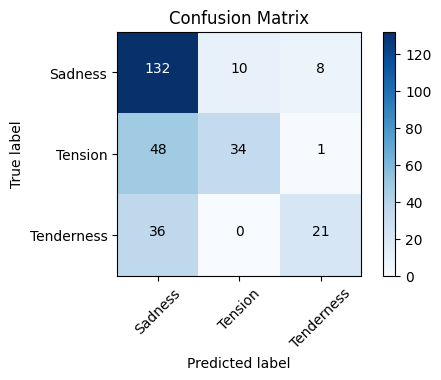

In [19]:
print("Model : Features : Model Accuracy : 5-fold cross-validation mean accuracy")
best_model_y_pred = list()
best_accuracy = 0
text_file = open("model_results.txt","w+")
for models in models_pipeline.keys():
    for tfv in n_gram_tfidf_features_pipeline.keys():
        pipeline = make_pipeline(n_gram_tfidf_features_pipeline[tfv], models_pipeline[models])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        tf_idf_vectorizer = n_gram_tfidf_features_pipeline[tfv]
        X_tf_idf = tf_idf_vectorizer.fit_transform(X)
        scores = cross_val_score(models_pipeline[models], X_tf_idf, y, cv=5)
        k_fold_mean_accuracy = ("%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        test_accuracy = accuracy_score(y_pred, y_test)
        test_accuracy_formatted = ("%0.2f" % (test_accuracy))
        stream = str(models) + " :" + str(tfv) + " :" + str(test_accuracy_formatted) + " :" + str(k_fold_mean_accuracy)
        print(stream)
        text_file.write(stream + "\n")
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model_y_pred = y_pred
text_file.close()
cnf_matrix = confusion_matrix(y_test, best_model_y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Sadness', 'Tension', 'Tenderness'], title='Confusion Matrix')
plt.savefig("cm.png", dpi=500)
plt.show()

### B: Multi-Label Classification

First we are going to take a look at the distribution of labels in our dataset.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
y = multi_label['labels']

In [22]:
y

0                                Calmness, Sadness
1                                   Power, Tension
2       Amazement, Calmness, Solemnity, Tenderness
3              Joyful activation, Sadness, Tension
4           Amazement, Calmness, Joyful activation
                           ...                    
1155                Nostalgia, Sadness, Tenderness
1156                   Calmness, Power, Tenderness
1157                     Power, Solemnity, Tension
1158                                    Tenderness
1159         Amazement, Calmness, Nostalgia, Power
Name: labels, Length: 1160, dtype: object

In [23]:
vectorizer = CountVectorizer()
emotion_dtm = vectorizer.fit_transform(y)
emotions = vectorizer.get_feature_names_out()
emotions

array(['activation', 'amazement', 'calmness', 'joyful', 'nostalgia',
       'power', 'sadness', 'solemnity', 'tenderness', 'tension'],
      dtype=object)

In [24]:
freqs = emotion_dtm.sum(axis=0).A1
result = dict(zip(emotions, freqs))
freq_count = pd.DataFrame(result.items(), columns=['Emotions', 'Counts'])
freq_sorted = freq_count.sort_values(['Counts'], ascending=False)
freq_sorted

,Emotions,Counts
6,sadness,574
9,tension,553
8,tenderness,498
5,power,477
4,nostalgia,438
7,solemnity,377
0,activation,349
3,joyful,349
2,calmness,250
1,amazement,239


In [25]:
# # Create a DataFrame
# df = pd.DataFrame(y)

# # Join the labels into single strings
# # You can customize the separator as needed
# df['labels'] = df['labels'].apply(lambda x: ' '.join(x.split(', ')))

# # Initialize the TF-IDF vectorizer
# tf_idf_vectorizer = TfidfVectorizer()

# # Fit and transform the data
# emotion_dtm = tf_idf_vectorizer.fit_transform(df['labels'])

# # Get the feature names
# emotions = tf_idf_vectorizer.get_feature_names_out()

# # Calculate the sum of TF-IDF scores for each term
# freqs = emotion_dtm.sum(axis=0).A1

# # Create a DataFrame for the results
# result = dict(zip(emotions, freqs))
# freq_count = pd.DataFrame(result.items(), columns=['Emotions', 'Counts'])

# # Sort the DataFrame
# freq_sorted = freq_count.sort_values(['Counts'], ascending=False)

# # Print or display the sorted DataFrame
# print(freq_sorted)

In [26]:
emotion_per_example = emotion_dtm.sum(axis=1).tolist()
emotion_per_example = [int(j) for i in emotion_per_example for j in i]
print('Maximum emotions per example: %d'%max(emotion_per_example))
print('Minimum emotions per example: %d'%min(emotion_per_example))
print('Average emotions per example: %f'% ((sum(emotion_per_example))/len(emotion_per_example)))

Maximum emotions per example: 8
Minimum emotions per example: 1
Average emotions per example: 3.537931


After taking a closer look at the data in hand, we proceed with solving the classification problem.

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

For this task we will need a Binarizer for the labels. As each example is annotated as more than one classes, we need to transform this information to a machine-readable format. But first, let's create X and y.

In [28]:
X = multi_label['lyrics']
X.head()

0    I will never bother you\nI will never promise ...
1    Here we go\nMy big ego is gonna get me in trou...
2    She came as Lolita dressed as Venus\nAnd adorn...
3    Ivory Madonna, dying in the dust\nWaiting for ...
4    I was totin' my pack along the dusty Winnemucc...
Name: lyrics, dtype: object

In [29]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(multi_label['labels'])
y

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 1]])

In the line above, our labels are transformed into arrays, where 1 indicates the presence of a specific class.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

For this problem we are using Logistic Regression-trained classifiers for each class, with the help of the OneVsRestClassifier. The data is again fed into the classifier via a pipeline, where it is transformed into vectors of TF/IDF features.

In [31]:
tfv = TfidfVectorizer(min_df=3, max_features=3000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=(1,1),
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
pipeline = make_pipeline(tfv, clf)

Now, that we have our model, we once again split into training and test sets to calculate our classifier's efficiency in classifying lyrics into sets of emotions' labels.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

Before we fit our classifiers, we import the f1-score metric to evaluate the efficiency of learning of our model.

In [33]:
from sklearn.metrics import f1_score

This time the average setting of f1_score is set to micro in order to aggregate the contributions of all classes and compute the average metric.

In [34]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('F1-SCORE :',f1_score(y_test, y_pred, average="micro"))

F1-SCORE : 0.8241781106949646


In [44]:
X_test.iloc[0]

'{Verse 1}\nI turn the TV off, to turn it on again\nStaring at the blades of the fan as it spins around\nCounting every crack, the clock is wide awake\nTalking to myself, anything to make a sound\n{Chorus}\nI told you I wouldn’t call, I told you I wouldn’t care\nBut baby climbing the walls gets me nowhere\nI don’t think that I can take this bed getting any colder\nCome over, come over, come over, come over, come over\n{Verse 2}\nYou can say we’re done the way you always do\nIt’s easier to lie to me than to yourself\nForget about your friends, you know they’re gonna say\nWe’re bad for each other, but we ain’t good for anyone else\n{Chorus}\nI told you I wouldn’t call, I told you I wouldn’t care\nBut baby climbing the walls gets me nowhere\nI don’t think that I can take this bed getting any colder\nCome over, come over, come over, come over, come over\n{Bridge}\nWe don’t have to miss each other, come over\nWe don’t have to fix each other, come over\nWe don’t have to say forever, come ove

In [47]:
y_pred

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 1, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0]])